In [15]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set()

In [2]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

/Users/travismcguire1/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


# Preprocess Data

## Fix Null Field Positions

In [3]:
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)

6424
(509762, 49)


In [4]:
# Handle 50 YardLine by filling in the null 'FieldPositions' with the value in 'PossessionTeam'
print(df[df.FieldPosition.isnull()][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']].head())
df.FieldPosition.fillna(df.PossessionTeam, inplace=True)
print(df[198:203][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']])

field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)

         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801           NaN             KC        50
199  2017090700  20170907000801           NaN             KC        50
200  2017090700  20170907000801           NaN             KC        50
201  2017090700  20170907000801           NaN             KC        50
202  2017090700  20170907000801           NaN             KC        50
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801            KC             KC        50
199  2017090700  20170907000801            KC             KC        50
200  2017090700  20170907000801            KC             KC        50
201  2017090700  20170907000801            KC             KC        50
202  2017090700  20170907000801            KC             KC        50
0
(509762, 49)


## Downsample, keep only entries where players is rusher

In [5]:
# Same gameid, same playid, same yards gained for the first 5 entries... hm..
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000118            NE             NE        35      8
2  2017090700  20170907000118            NE             NE        35      8
3  2017090700  20170907000118            NE             NE        35      8
4  2017090700  20170907000118            NE             NE        35      8
(509762, 49)


In [6]:
df = df[df['NflIdRusher']==df['NflId']] # only keep entries associated with the rusher
df.reset_index(drop=True, inplace=True)
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000139            NE             NE        43      3
2  2017090700  20170907000189            KC             NE        35      5
3  2017090700  20170907000345            KC             NE         2      2
4  2017090700  20170907000395            KC             KC        25      7
(23171, 49)


## Calculate number of yards remaining 

In [7]:
df['YardsRemaining'] = 100 - df.YardLine[df.FieldPosition == df.PossessionTeam]
df.YardsRemaining.fillna(df.YardLine, inplace=True)
df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards', 'YardsRemaining']]

,GameId,PlayId,FieldPosition,PossessionTeam,YardLine,Yards,YardsRemaining
0,2017090700,20170907000118,NE,NE,35,8,65.0
1,2017090700,20170907000139,NE,NE,43,3,57.0
2,2017090700,20170907000189,KC,NE,35,5,35.0
3,2017090700,20170907000345,KC,NE,2,2,2.0
4,2017090700,20170907000395,KC,KC,25,7,75.0


# Train and Dev Split

In [8]:
train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)

In [9]:
print(train.shape)
print(dev.shape)

(16219, 50)
(6952, 50)


# Perform MLE

## Calculate CDF with all data

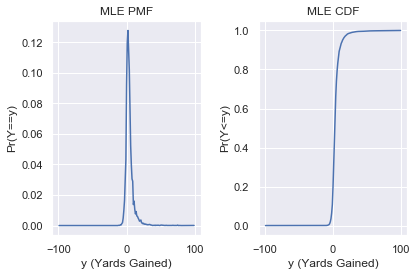

In [25]:
# calculate pmf 
yard_counts = np.zeros((199), dtype = 'double')
for yard in range(-99, 100):
    yard_counts[yard+99] = sum(train['Yards']==yard)
yard_probabilities = yard_counts / np.sum(yard_counts)

# calculate cdf
yard_cdf = np.cumsum(yard_probabilities)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), yard_probabilities)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y==y)', title='MLE PMF')
axes[1].plot(np.arange(-99,100), yard_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF')
plt.tight_layout()

## Squashing probabilities 

In [26]:
# squash probabilities
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

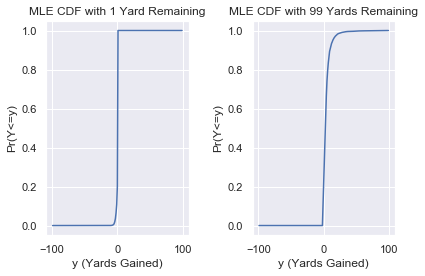

In [32]:
one_cdf = squash(yard_cdf, 1)
ninenine_cdf = squash(yard_cdf, 99)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), one_cdf)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF with 1 Yard Remaining')
axes[1].plot(np.arange(-99,100), ninenine_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF with 99 Yards Remaining')
plt.tight_layout()

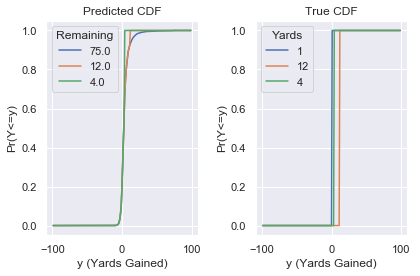

In [43]:
fig, axes = plt.subplots(1, 2)

for index, row in dev.head().iterrows():
    if index in [7177, 5312, 15852]:
        pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
        axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'])
        true_cdf = np.zeros(199)
        true_cdf[99+row['Yards']:] = 1
        axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'])
        (pred_cdf-true_cdf)**2

    
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Predicted CDF')
axes[0].legend(title='Remaining')
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='True CDF')
axes[1].legend(title='Yards')
plt.tight_layout()

## Loss for model using all of the data

In [136]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014044054093647522


# Perform MLE Segmented by Yardline

## Find model for each yard line

In [44]:
yard_counts = np.zeros((99,199), dtype = 'uint32')
yard_probabilities = np.zeros((99,199), dtype = 'float')

for yard_remaining in range(1,100):
    yards_current = train.Yards[train['YardsRemaining']==yard_remaining]
    
    for yard in range(-99, 100):
        yard_counts[yard_remaining-1,yard+99] = sum(yards_current==yard)
        
    yard_probabilities[yard_remaining-1,:] = yard_counts[yard_remaining-1,:] / np.sum(yard_counts[yard_remaining-1,:])
    
# CDF 
yard_cdf = np.zeros(yard_probabilities.shape)
for yard_remaining in range(1, 100):
    yard_cdf[yard_remaining-1] = np.cumsum(yard_probabilities[yard_remaining-1,:])

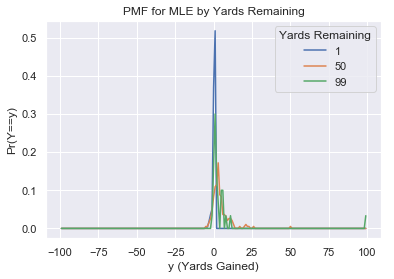

In [54]:
for yard_line in [1,50,99]:
    yard_line_index = yard_line -1
    plt.plot(np.arange(-99,100),yard_probabilities[yard_line_index,:], label = str(yard_line))
    
plt.title('PMF for MLE by Yards Remaining')
plt.ylabel('Pr(Y==y)')
plt.xlabel('y (Yards Gained)')
plt.legend(title='Yards Remaining');

In [51]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf[int(row['YardsRemaining'])-1,:], int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014088655099676866


# Boosted MLE by Yardline

## Using Gaussian kernel method to boost models for each yard line

In [52]:
#tune this as needed
sigma = 16
boosted_cdf = np.zeros(199)
weights = []
for true_remaining in range(1,100):
    for model_remaining in range (1,100):
        yard_line_cdf = yard_cdf[model_remaining-1,:]
        weight = np.exp(-((true_remaining - model_remaining)**2) / (2*(sigma**2)))
        weights.append(weight)
        boosted_cdf += weight*yard_line_cdf
        
#normalize the cdf
boosted_cdf /= np.sum(weights)  

## Compute loss for weighted model

In [53]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(boosted_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014044888138695224
